In [1]:
from fbprophet import Prophet

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import pymc3 as pm

%matplotlib inline

plt.rcParams['figure.figsize'] = 15, 5
plt.rcParams['font.size'] = 14

In [4]:
weather = pd.read_csv("data/eindhoven.txt")
# clean whitespaces in the columns
weather.columns = [c.replace(" ", "") for c in weather.columns]

# Parse date information
weather['date'] = (weather['YYYYMMDD']
  .astype(str)
  .map(lambda date: f"{date[:4]}-{date[4:6].zfill(2)}-{date[6:8].zfill(2)}"))
weather['date'] = pd.to_datetime(weather['date'])

# Get correct types for a selection of columns
weather['max_temp'] = pd.to_numeric(weather['TX'].str.strip())
weather['min_temp'] = pd.to_numeric(weather['TN'].str.strip())
weather['rain'] = pd.to_numeric(weather['RH'].str.strip())
weather['sunshine_duration'] = pd.to_numeric(weather['SQ'].str.strip())
weather['solar_energy'] = pd.to_numeric(weather['Q'].str.strip())

# Keep a selection of columns
keep_columns = ['date', 'min_temp', 'max_temp', 'rain', 'sunshine_duration', 'solar_energy']
weather = weather[keep_columns].fillna(0)

# Adding features
weather['day_of_week'] = weather.date.dt.weekday_name
weather['week_of_year'] = weather.date.dt.weekofyear
weather['month'] = weather.date.dt.month
weather['year'] = weather.date.dt.year

/anaconda3/envs/acceleratorX/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2,3,4,11,12,13,14,15,16,17,18,19,20,25,26,27,28,29,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
temp = weather[['date', 'max_temp']]
temp.columns = ['ds', 'y']
temp = temp[temp['ds'] < pd.datetime(1995, 1, 1)]

In [8]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.fit(temp)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

/anaconda3/envs/acceleratorX/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


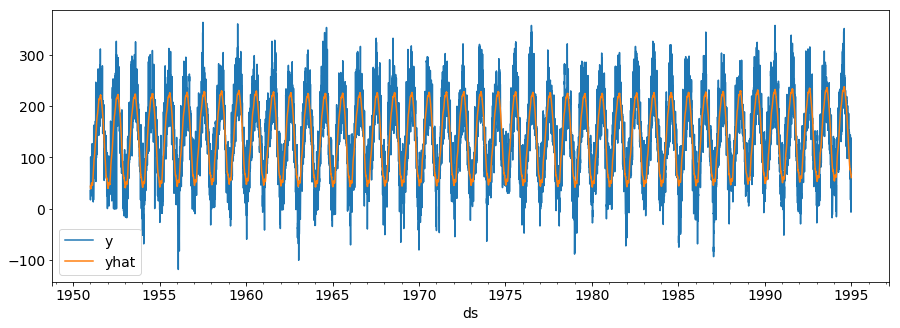

In [10]:
temp.merge(forecast, on='ds', how='inner').plot(x='ds', y = ['y', 'yhat'])

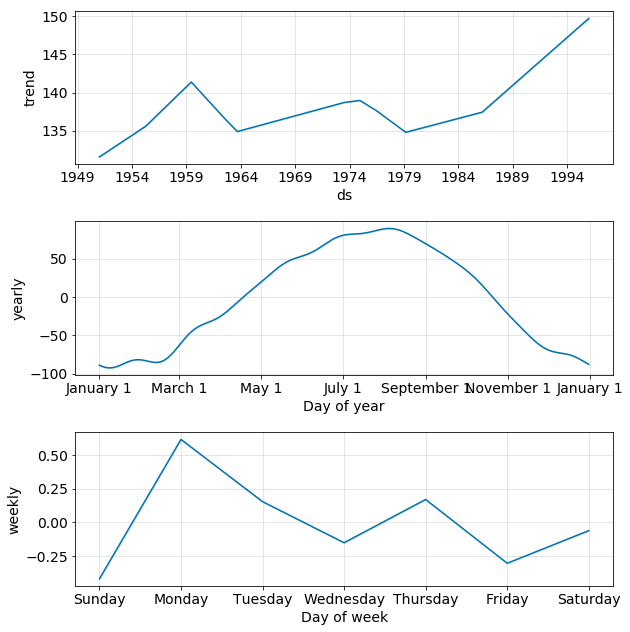

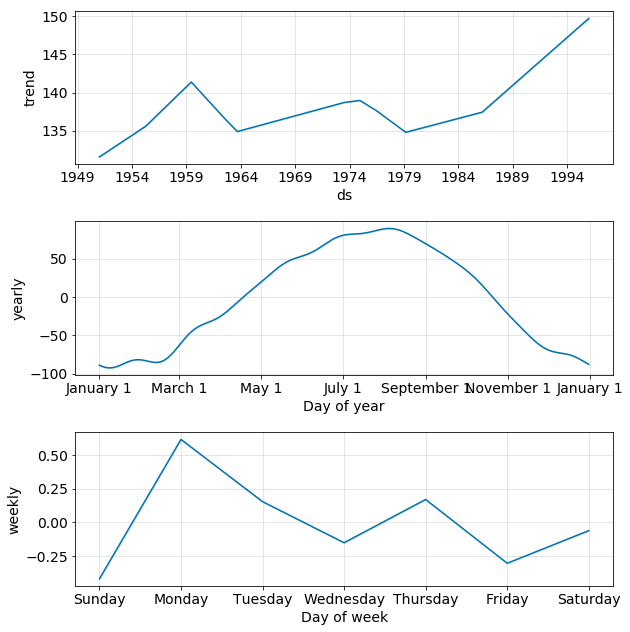

In [12]:
model.plot_components(forecast)

In [14]:
temp = temp.merge(forecast, on='ds', how='inner')
temp['diff'] = temp.y - temp.yhat